# V100. Tensorflow HP benchmark
## Combined profile

Profiled on p3.2xlarge (V100), CUDA9.0
```
$ ubuntu@ip-172-31-21-194:~$ ./comb_profile.sh ./run_tfhp.sh TFHP_combined_v100_50ms

```

In [3]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

# Plot combined profiling

In [4]:
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17
name_field_index = 18

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

columns = [time_field_index, duration_field_index,
           size_field_index, throughput_field_index,
           src_field_index, dst_field_index,
           context_index, stream_index,
           name_field_index]

maxrows = None

In [5]:
!ls *.csv

TFHP_combined_v100-nvidia-smi.csv
TFHP_combined_v100-nvprof-trace-13124.csv
TFHP_combined_v100_50ms-nvidia-smi.csv
TFHP_combined_v100_50ms-nvprof-trace-13339.csv


In [270]:
filename_nvsmi_tf = "TFHP_combined_v100_50ms-nvidia-smi.csv"
filename_nvprof_tf = "TFHP_combined_v100_50ms-nvprof-trace-13339.csv"

df_nvprof = pd.read_csv(filename_nvprof_tf,header = 0, usecols = columns, skiprows=[0,1,2,4], nrows = maxrows)
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
245820,15.545091,0.001695,NaN,NaN,NaN,NaN,1,14,void Eigen::internal::EigenMetaKernel<Eigen::T...
245821,15.545093,0.002496,NaN,NaN,NaN,NaN,1,14,void Eigen::internal::EigenMetaKernel<Eigen::T...
245822,15.545097,0.002368,NaN,NaN,NaN,NaN,1,14,_ZN5Eigen8internal15EigenMetaKernelINS_15Tenso...
245823,15.545100,0.001824,NaN,NaN,NaN,NaN,1,14,_ZN5Eigen8internal15EigenMetaKernelINS_15Tenso...
245824,15.545103,0.002592,NaN,NaN,NaN,NaN,1,14,_ZN5Eigen8internal15EigenMetaKernelINS_15Tenso...


# Remove rows with no Throughput

In [271]:
df_nvprof = df_nvprof.loc[df_nvprof["Throughput"].notnull()]
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
245752,15.538431,0.001312,0.062500,46.520698,Device,NaN,1,14,[CUDA memset]
245761,15.539383,0.001312,0.062500,46.520698,Device,NaN,1,14,[CUDA memset]
245783,15.540836,0.001344,0.140625,102.179391,Device,NaN,1,14,[CUDA memset]
245800,15.542037,0.001440,0.015625,10.596381,Device,NaN,1,14,[CUDA memset]
245816,15.544087,0.001312,0.035889,26.713057,Device,NaN,1,14,[CUDA memset]


In [272]:
print df_nvprof.shape
print df_nvprof.Name.unique()

(18827, 9)
['[CUDA memset]' '[CUDA memcpy HtoD]' '[CUDA memcpy DtoD]'
 '[CUDA memcpy DtoH]']


In [273]:
nvprof = df_nvprof.loc[~df_nvprof["Name"].str.contains("memset")]
print nvprof.Name.unique()

['[CUDA memcpy HtoD]' '[CUDA memcpy DtoD]' '[CUDA memcpy DtoH]']


### Group by SRC and DST memory type

In [274]:
#nvprof['FullName'] = nvprof['Name']
nvprof['FullName'] = nvprof['Name'] + " " + nvprof['SrcMemType']+ nvprof['DstMemType'].fillna("")
nvprof.drop(['Name'], axis=1, inplace=True)
print nvprof.FullName.unique()
print nvprof.shape
nvprof.iloc[:15]

['[CUDA memcpy HtoD] PinnedDevice' '[CUDA memcpy DtoD] DeviceDevice'
 '[CUDA memcpy HtoD] PageableDevice' '[CUDA memcpy DtoH] DevicePinned']
(2166, 9)


/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,FullName
1,1.430609,0.001760,0.000004,0.002117,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
2,1.430750,0.001536,0.000004,0.002425,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
3,1.430907,0.001536,0.000244,0.155220,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
4,1.431014,0.001536,0.000244,0.155220,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
5,1.431199,0.001504,0.000004,0.002477,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
6,1.431293,0.001504,0.000004,0.002477,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
7,1.431395,0.001632,0.000977,0.584359,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
8,1.431498,0.001632,0.000977,0.584359,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
9,1.431717,0.001504,0.000004,0.002477,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
10,1.431811,0.001472,0.000004,0.002531,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice


In [341]:
throughput = nvprof.rename(columns={"Start":"sec"})
throughput.drop(throughput.columns[[1,2,4,5,6,7]],axis=1,inplace=True)
throughput.iloc[:3]

,sec,Throughput,FullName
1,1.430609,0.002117,[CUDA memcpy HtoD] PinnedDevice
2,1.430750,0.002425,[CUDA memcpy HtoD] PinnedDevice
3,1.430907,0.155220,[CUDA memcpy HtoD] PinnedDevice


In [342]:
throughput.set_index("sec",drop=True,inplace=True)
throughput.iloc[:3]

,Throughput,FullName
sec,,
1.430609,0.002117,[CUDA memcpy HtoD] PinnedDevice
1.430750,0.002425,[CUDA memcpy HtoD] PinnedDevice
1.430907,0.155220,[CUDA memcpy HtoD] PinnedDevice


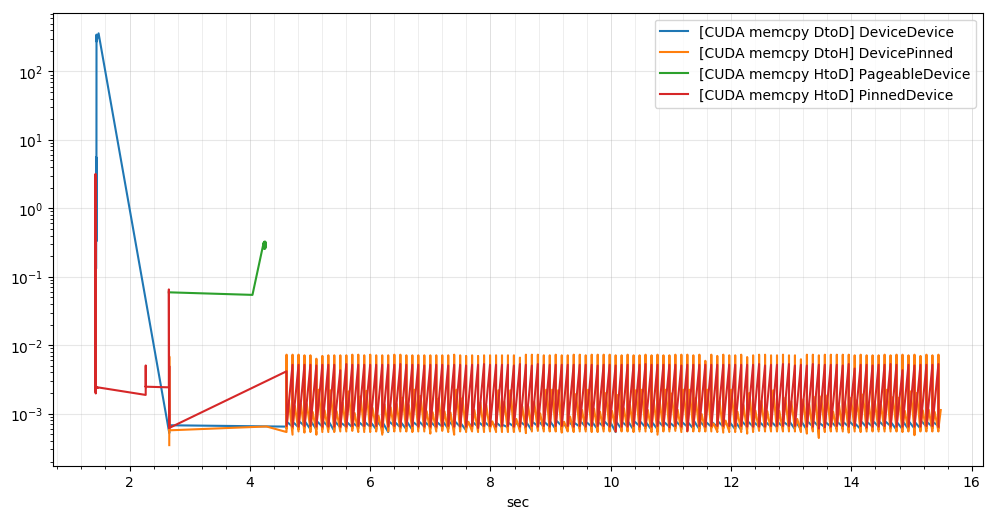

In [373]:
# Split one dataframe into several by names in FullName
fig, ax = plt.subplots(figsize=(12,6))
#throughput.groupby("FullName").plot()
for label, df in throughput.groupby("FullName"):
#     print label,type(df)
#     print df.iloc[:1]
    df.plot(ax=ax, y="Throughput",label=label,logy=True)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.xaxis.set_minor_locator(plt.MaxNLocator(50))
ax.xaxis.grid(linewidth=0.5,alpha=0.3,which="both")
ax.yaxis.grid(alpha=0.3)
plt.legend()

In [263]:
dd = nvprof.loc[nvprof["Name"].str.contains("DtoD")]
print dd.shape
dd.loc[dd["Throughput"] > 1]

(601, 9)


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,FullName
132,1.445895,0.002272,0.007812,3.358008,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
136,1.445952,0.001536,0.007812,4.967054,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
139,1.445991,0.001376,0.007812,5.544618,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
143,1.446051,0.001376,0.007812,5.544618,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
148,1.446120,0.001536,0.001953,1.241763,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
149,1.446134,0.001376,0.001953,1.386155,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
150,1.446147,0.001568,0.001953,1.216421,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
151,1.446160,0.001344,0.001953,1.419158,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
153,1.446190,0.001536,0.001953,1.241763,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice
164,1.446348,0.001376,0.001953,1.386155,Device,Device,1,14,[CUDA memcpy DtoD] DeviceDevice


In [264]:
dh = nvprof.loc[~nvprof["Name"].str.contains("DtoD")]
print dh.shape
dh.iloc[:3]

(1565, 9)


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,FullName
1,1.430609,0.001760,0.000004,0.002117,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
2,1.430750,0.001536,0.000004,0.002425,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice
3,1.430907,0.001536,0.000244,0.155220,Pinned,Device,1,15,[CUDA memcpy HtoD] PinnedDevice


In [ ]:
dh.iloc[:3,]

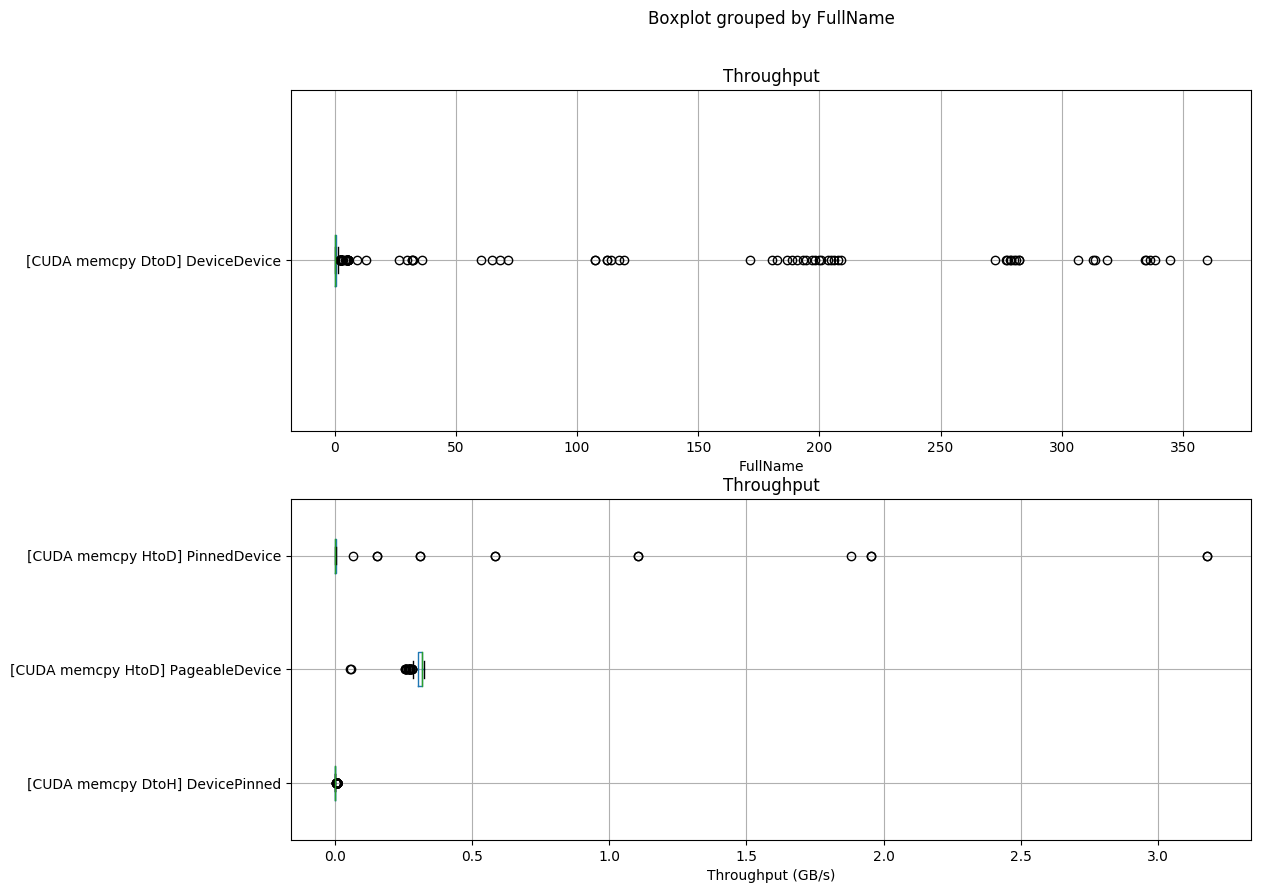

In [308]:
plt.rcParams['figure.figsize'] = 12,10
fig, axarr = plt.subplots(2,1)
dd.boxplot(column="Throughput",by="FullName",ax=axarr[0],vert=False)
dh.boxplot(column="Throughput",by="FullName",ax=axarr[1],vert=False)
ax = plt.gca()
ax.set_xlabel('Throughput (GB/s)')
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = 12,10
fig, axarr = plt.subplots(2,1)
dd.plot(column="Throughput",by="FullName",ax=axarr[0],vert=False)
dh.plot(column="Throughput",by="FullName",ax=axarr[1],vert=False)
ax = plt.gca()
ax.set_xlabel('Throughput (GB/s)')

In [266]:
# Convert unique values in column "FullName" to new columns
def mergeColumnNames(df_org):
    df = df_org.pivot(index="Start", columns="FullName", values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df

In [267]:
df_throughput = mergeColumnNames(nvprof)
df_throughput.iloc[:3]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice
Start,,,,
1.430609,0.0,0.0,0.0,0.002117
1.430750,0.0,0.0,0.0,0.002425
1.430907,0.0,0.0,0.0,0.155220


In [268]:
def appendMaxValues2ColumnNames(df,series):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        name = df.columns[i].replace("[CUDA memcpy ","")
        name = name.replace("]","")
        col_names.append(series+name+" " +'{:.3f}'.format(df.iloc[:,i].max()))
    df.columns = col_names
    return df

In [269]:
df_throughput = appendMaxValues2ColumnNames(df_throughput,"")
df_throughput.columns

Index([u'DtoD DeviceDevice 360.169', u'DtoH DevicePinned 0.007',
       u'HtoD PageableDevice 0.324', u'HtoD PinnedDevice 3.179'],
      dtype='object')

##### Rename Start column

In [140]:
df_throughput.index.names = ["sec"]

In [389]:
dd = df_throughput.filter(regex=(".*DtoD.+"))
dd.iloc[:3]

,DtoD DeviceDevice 360.169
Start,
1.430609,0.0
1.430750,0.0
1.430907,0.0


In [390]:
dh = df_throughput.filter(regex=(".*(HtoD|DtoH).*"))
dh.iloc[:3]

,DtoH DevicePinned 0.007,HtoD PageableDevice 0.324,HtoD PinnedDevice 3.179
Start,,,
1.430609,0.0,0.0,0.002117
1.430750,0.0,0.0,0.002425
1.430907,0.0,0.0,0.155220


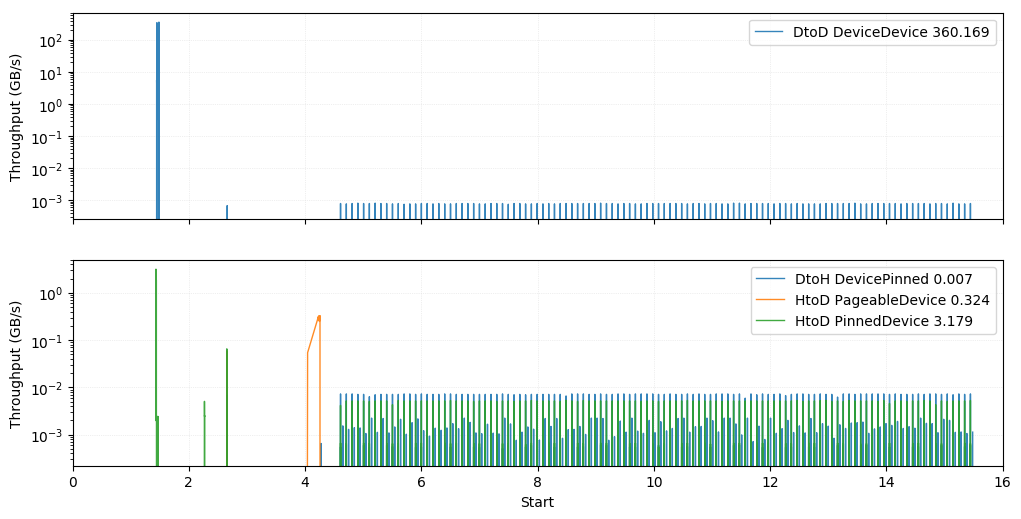

In [391]:
plt.rcParams['figure.figsize'] = 12,6
fig, axarr = plt.subplots(2,sharex=True)
dd.plot(linewidth=1,alpha=0.9,ax = axarr[0],logy=True)
dh.plot(linewidth=1,alpha=0.9,ax = axarr[1],logy=True)
for ax in axarr:
    ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.set_ylabel('Throughput (GB/s)')
    ax.set_xlim(0,16)

In [146]:
# PCI express x3 bandwidth
PCI3_band = 16 # GB/s

In [156]:
# Device DRAM bandwidth
# Memory clock rate
GHz=1.75
# Interface width
bit=4096

DRAM_GBs=(GHz * 1e9 * (bit/8)) / 1e9
print PCI3_band, DRAM_GBs

16 896.0


#### Normalize H<->D throughput

In [162]:
norm = df_throughput.copy()
def normalize(x,max = 16):
    #print "max=",max 
    if isinstance(x,int) or isinstance(x,float):
        if x == 0:
            return 0
        else:
            x_ = float(x)
            max_ = float(max)
            norm = (x_/max_)*100
            #print x_,norm
            return norm
    elif x is None:
        return x
    else:
        print "Wrong parameter type:",type(x)

def normalize_df(x,max = 16):
    #print type(x)
    if isinstance(x,int) or isinstance(x,float):
        return normalize(x,max)
    else:
        #print x.values
        x = x.apply(normalize,max=max)
        #print "Returned:",type(x)
        #print x.values
        return x
    
       
norm.iloc[:,2:] = norm.iloc[:,1:].apply(normalize_df, max = PCI3_band)
norm.iloc[:,0] = norm.iloc[:,0].apply(normalize_df, max = DRAM_GBs)
norm[df_throughput.iloc[:,0] > 300]

,DtoD DeviceDevice 360.169,DtoH DevicePinned 0.007,HtoD PageableDevice 0.324,HtoD PinnedDevice 3.179
sec,,,,
1.450357,37.338592,0.0,0.0,0.0
1.450494,37.533072,0.0,0.0,0.0
1.450652,38.463010,0.0,0.0,0.0
1.450727,34.933125,0.0,0.0,0.0
1.450823,35.571590,0.0,0.0,0.0
1.450895,37.799012,0.0,0.0,0.0
1.450969,35.025741,0.0,0.0,0.0
1.451043,34.230952,0.0,0.0,0.0
1.451098,37.359037,0.0,0.0,0.0


In [398]:
ddnorm = dd.copy()
dhnorm = dh.copy()
dhnorm = dhnorm.apply(normalize_df, max = PCI3_band)
ddnorm = ddnorm.apply(normalize_df, max = DRAM_GBs)
ddnorm[dd.iloc[:,0] > 300]

,DtoD DeviceDevice 360.169
Start,
1.450357,37.338592
1.450494,37.533072
1.450652,38.463010
1.450727,34.933125
1.450823,35.571590
1.450895,37.799012
1.450969,35.025741
1.451043,34.230952
1.451098,37.359037


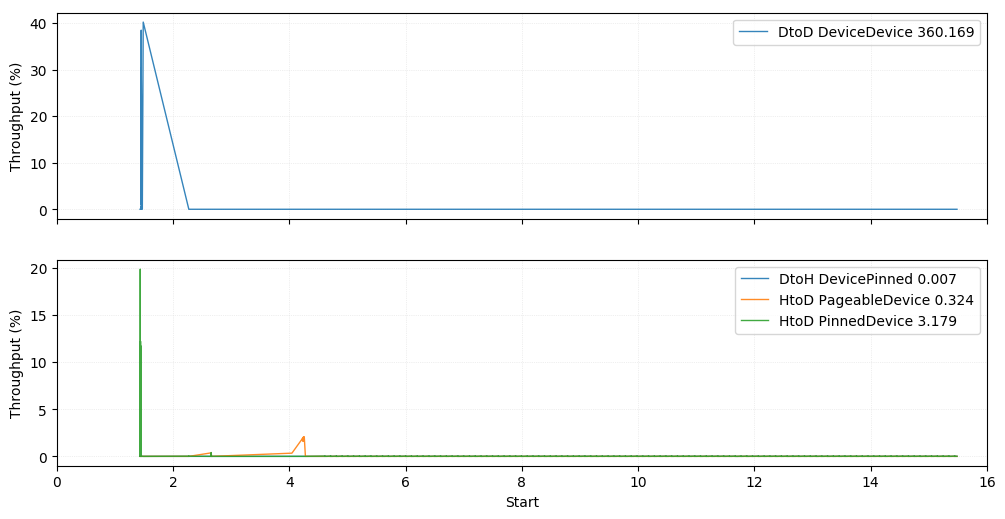

In [400]:
plt.rcParams['figure.figsize'] = 12,6
fig, axarr = plt.subplots(2,sharex=True)
ddnorm.plot(linewidth=1,alpha=0.9,ax = axarr[0],logy=False)
dhnorm.plot(linewidth=1,alpha=0.9,ax = axarr[1],logy=False)
for ax in axarr:
    ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.set_ylabel('Throughput (%)')
    ax.set_xlim(0,16)

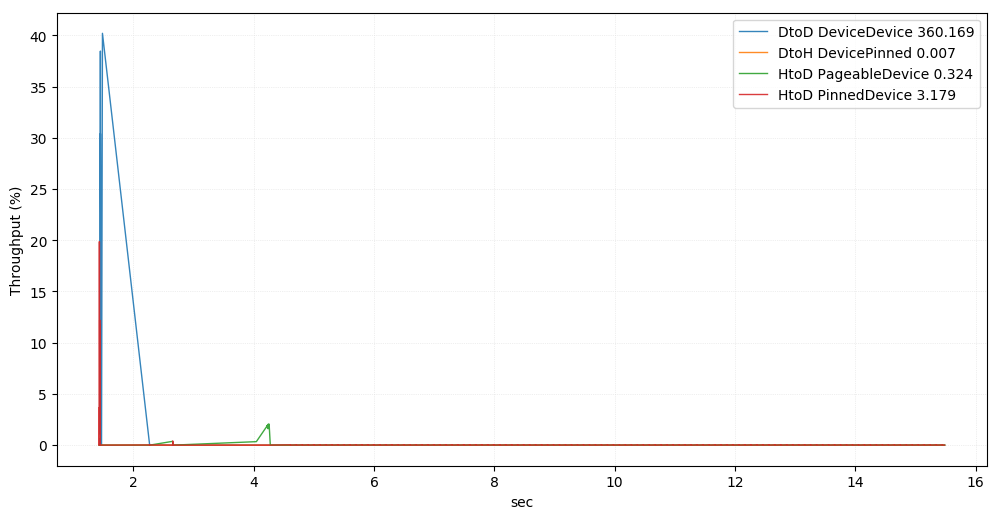

In [169]:
# plt.rcParams['figure.figsize'] = 12,8
# norm.plot(linewidth=0.9,alpha=0.8)
# ax = plt.gca()
# ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
# ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
# #ax.xaxis.set_major_locator(plt.MaxNLocator(24))
# ax.set_xlabel('Start (s)')
# ax.set_ylabel('Throughput (%)')
# plt.show()


plt.rcParams['figure.figsize'] = 12,6
fig, ax = plt.subplots(1)
norm.plot(linewidth=1,alpha=0.9,ax = ax,logy=False)
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
ax.set_ylabel('Throughput (%)')
plt.show()

# Plot smi data

In [375]:
filename = filename_nvsmi_tf
print "Reading",filename
start = 0
smi_data = pd.read_csv(filename,skiprows=[0,1],header=0)
smi_data.iloc[:3]

Reading TFHP_combined_v100_50ms-nvidia-smi.csv


,time nvsmi,time python,gpu,PCI sent,PCI recv,GPU util,Memory util,13293 Used Memory
0,Wed Feb 7 05:43:54 2018,2018-02-07 05:43:54.811541,Tesla V100-SXM2-16GB,15000 KB/s,1719000 KB/s,0 %,0 %,424 MiB
1,Wed Feb 7 05:43:54 2018,2018-02-07 05:43:54.910300,Tesla V100-SXM2-16GB,24000 KB/s,107000 KB/s,4 %,0 %,446 MiB
2,Wed Feb 7 05:43:54 2018,2018-02-07 05:43:55.010011,Tesla V100-SXM2-16GB,28000 KB/s,233000 KB/s,10 %,1 %,472 MiB


In [376]:
# Parse date from readable format to seconds
def parseTime(date_time):
    global start
    dt_obj = datetime.datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        start = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

In [377]:
smi_data["sec"] = smi_data["time python"].apply(parseTime)
smi_data.iloc[:3]

,time nvsmi,time python,gpu,PCI sent,PCI recv,GPU util,Memory util,13293 Used Memory,sec
0,Wed Feb 7 05:43:54 2018,2018-02-07 05:43:54.811541,Tesla V100-SXM2-16GB,15000 KB/s,1719000 KB/s,0 %,0 %,424 MiB,0.000000
1,Wed Feb 7 05:43:54 2018,2018-02-07 05:43:54.910300,Tesla V100-SXM2-16GB,24000 KB/s,107000 KB/s,4 %,0 %,446 MiB,0.098759
2,Wed Feb 7 05:43:54 2018,2018-02-07 05:43:55.010011,Tesla V100-SXM2-16GB,28000 KB/s,233000 KB/s,10 %,1 %,472 MiB,0.198470


In [378]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(str):
    global pat
    f = pat.search(str)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [379]:
smi = smi_data.rename(columns={"GPU util":"GPU util (%)","Memory util":"Memory util (%)"})
smi = smi.drop(columns = ['time nvsmi', 'time python', 'gpu'])
print smi.iloc[:2]
smi.set_index("sec", drop=True, inplace=True)
smi.iloc[:3]

     PCI sent      PCI recv GPU util (%) Memory util (%) 13293 Used Memory  \
0  15000 KB/s  1719000 KB/s          0 %             0 %           424 MiB   
1  24000 KB/s   107000 KB/s          4 %             0 %           446 MiB   

        sec  
0  0.000000  
1  0.098759  


,PCI sent,PCI recv,GPU util (%),Memory util (%),13293 Used Memory
sec,,,,,
0.000000,15000 KB/s,1719000 KB/s,0 %,0 %,424 MiB
0.098759,24000 KB/s,107000 KB/s,4 %,0 %,446 MiB
0.198470,28000 KB/s,233000 KB/s,10 %,1 %,472 MiB


In [380]:
smi = smi.applymap(parseFloat)
smi.iloc[:3]

,PCI sent,PCI recv,GPU util (%),Memory util (%),13293 Used Memory
sec,,,,,
0.000000,15000.0,1719000.0,0.0,0.0,424.0
0.098759,24000.0,107000.0,4.0,0.0,446.0
0.198470,28000.0,233000.0,10.0,1.0,472.0


In [381]:
smi.iloc[:,[0,1]] = smi.iloc[:,[0,1]].apply(lambda x: x/1e6)
smi.rename(columns={smi.columns[0]:"PCI sent (GB/s)",smi.columns[1]:"PCI recv (GB/s)"},
                inplace=True)

#Mib to GB conversion: 1 MiB = 0.001048576 GB (1MiB=2^20=1 048 576 bytes, 1GB = 1 000 000 000 bytes
smi.iloc[:,4] = smi.iloc[:,4].apply(lambda x: x*0.001048576)
smi.rename(columns={smi.columns[4]:"Used Memory (GB)"}, inplace=True)
smi.iloc[:3]

,PCI sent (GB/s),PCI recv (GB/s),GPU util (%),Memory util (%),Used Memory (GB)
sec,,,,,
0.000000,0.015,1.719,0.0,0.0,0.444596
0.098759,0.024,0.107,4.0,0.0,0.467665
0.198470,0.028,0.233,10.0,1.0,0.494928


In [415]:
Mem = smi.iloc[:,[4]]
# Memsize of V100 = 16.9GB
Mem["Total (GB)"]=16.9
Util = smi.iloc[:,[2,3]]
Thrg = smi.iloc[:,[0,1]]
Mem.iloc[-5:]

/Users/peterbryzgalov/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,Used Memory (GB),Total (GB)
sec,,
13.061020,16.345203,16.9
13.161172,16.345203,16.9
13.260662,16.345203,16.9
13.361092,16.345203,16.9
13.463650,16.345203,16.9


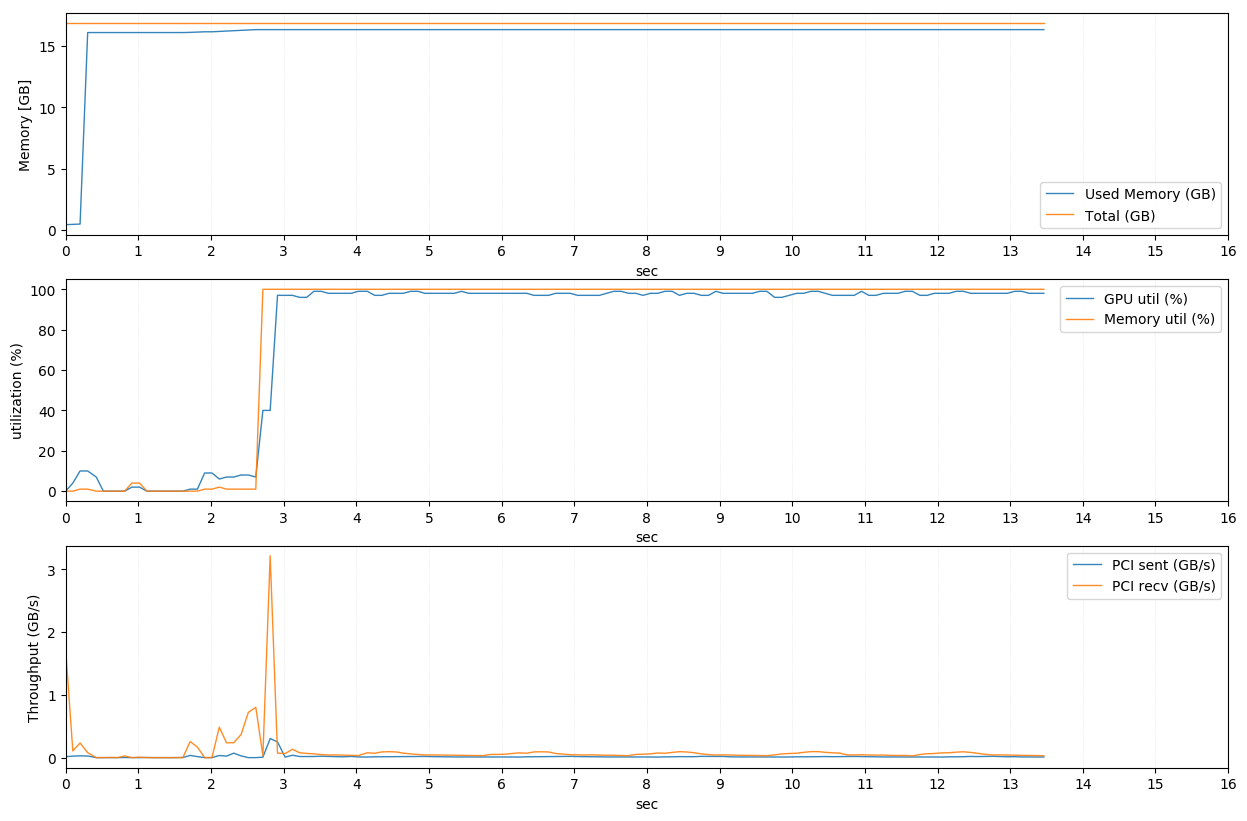

In [416]:
plt.rcParams['figure.figsize'] = 15,10
fig, axarr = plt.subplots(3)
Mem.plot(linewidth=1,alpha=0.9,ax = axarr[0])
Util.plot(linewidth=1,alpha=0.9,ax = axarr[1])
Thrg.plot(linewidth=1,alpha=0.9,ax = axarr[2])
axarr[0].set_ylabel('Memory [GB]')
axarr[1].set_ylabel('utilization (%)')
axarr[2].set_ylabel('Throughput (GB/s)')
for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(16))
    axis.set_xlim(left=0,right=16)
    #axis.xaxis.set_major_locator(dates.SecondLocator(bysecond = range(120), interval = 10))
    #axis.xaxis.set_minor_locator(dates.MicrosecondLocator(interval = 1000))
    #axis.xaxis.set_major_formatter(dates.DateFormatter('%S:%f'))
plt.show()